In [1]:
import gc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import accuracy_score, precision_score

from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
class Learner():
    def __init__(self, classes : tuple, n_estimators : tuple, max_depths : tuple, train_df : pd.DataFrame, test_df : pd.DataFrame, submission_df : pd.DataFrame):
        self.classes = classes
        self.n_estimators = n_estimators
        self.max_depths = max_depths
        self.train_df = train_df
        self.test_df = test_df
        self.submission_df = submission_df

        self.scored_classifiers = []
        self.classification_reports = []
    
    def split_dataset(self):        
        self.train_input, self.validation_input, self.train_output, self.validation_output = tts(self.train_df.drop(columns=["id", "status_group"]), self.train_df["status_group"], test_size=0.3)
        return self.train_input, self.validation_input, self.train_output, self.validation_output
    
    def create_file(self, predicited_output, file_num : str):
        if predicited_output.shape[0] == self.submission_df.shape[0]:
            print(True)
            submission = self.submission_df.copy()
            for (idx,data) in submission["status_group"].iteritems():
                submission["status_group"][idx] = self.classes[predicited_output[idx]]                
            submission.to_csv("./datasets/submissions/submission_" + file_num + ".csv", index=False, header=True)
            del submission
            gc.collect()
    
    def create_classifier(self, depth : int, estimator : int):
        classifer_model = RandomForestClassifier(max_depth=depth, n_estimators=estimator, n_jobs=-1)
        return classifer_model
    
    def train_model(self):
        dataset = self.split_dataset()
        for estimator in n_estimators:
            for max_depth in max_depths:
                classifier = self.create_classifier(depth=max_depth, estimator=estimator)
                classifier.fit(dataset[0], dataset[2])
                predicted_output = classifier.predict(dataset[1])
                acc_score = accuracy_score(predicted_output, dataset[3])

                self.classification_reports.append(self.create_classification_report(dataset[3], predicted_output)                )
                self.scored_classifiers.append((estimator, max_depth, classifier, acc_score))
    
    def test_model(self, classifier : RandomForestClassifier,file_num : int,  create_file=True):
        self.test_df = self.test_df.fillna(self.test_df.median())
        predicted_output = classifier.predict(self.test_df.drop(columns=["id"]))
        if create_file:
            self.create_file(predicted_output, str(file_num))
        return predicted_output
    
    def plot_confusion_matrix(self, classifier : RandomForestClassifier):
        plot_conf_matrix = plot_confusion_matrix(classifier, self.validation_input, self.validation_output, display_labels=classes, cmap=plt.cm.Blues, normalize='true') 
        return plot_conf_matrix
    
    def create_classification_report(self, validation_output, predicted_output):
        report = classification_report(validation_output, predicted_output, output_dict=True)   
        return pd.DataFrame(report).transpose()
    
    def get_cross_validation_score(self, classifier : RandomForestClassifier):
        return cross_val_score(classifier, self.validation_input, self.validation_output, cv=3)

## Public Variables

In [3]:
classes = ("functional", "functional needs repair","non functional")
n_estimators = (800, 1000)
max_depths = (40, 41, 42)

In [4]:
train_df = pd.read_csv("./datasets/preprocessed_data/merged_train.csv")
test_df = pd.read_csv("./datasets/preprocessed_data/test.csv")
submission_df = pd.read_csv("./datasets/SubmissionFormat.csv")

In [5]:
train_df.drop('date_recorded', axis=1, inplace=True)
test_df.drop('date_recorded', axis=1, inplace=True)
#test_df.drop('status_group',axis=1, inplace=True)

In [6]:
train_df.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,1559.0,1390,1764.0,34.938093,-9.856322,5520,0,1,...,2,5,3,3,3,2,2,0,0,0
1,8776,0.0,1731.0,1399,1868.0,34.698766,-2.147466,17493,0,3,...,2,5,4,4,0,0,0,0,0,0
2,34310,25.0,1431.0,686,1732.0,37.460664,-3.821329,37342,0,4,...,2,5,3,3,5,3,0,3,0,0
3,67743,0.0,1265.0,263,1254.0,38.486161,-11.155298,12,0,5,...,2,5,1,1,4,5,2,3,0,2
4,19728,0.0,1555.0,0,1454.0,31.130847,-1.825359,29877,0,3,...,2,5,2,2,0,0,0,0,0,0


In [7]:
test_df.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,1795.0,1996,1832.0,35.290799,-4.059696,7003,0,6,...,3,2,5,2,2,0,0,0,6,5
1,51630,0.0,1967.0,1569,1300.0,36.656709,-3.309214,14711,0,4,...,3,2,5,4,4,3,2,2,0,0
2,17168,0.0,1334.0,1567,1300.0,34.767863,-5.004344,14742,0,6,...,3,2,5,4,4,0,0,0,6,5
3,45559,0.0,381.0,267,2349.0,38.058046,-9.418672,7335,0,5,...,2,2,5,1,1,2,1,2,6,5
4,49871,500.0,615.0,1260,774.0,35.006123,-10.950412,30637,0,5,...,1,2,5,3,3,3,2,2,0,0


In [8]:
submission_df.head(5)

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


## Train the Model then predict the test values

In [9]:
learner = Learner(classes=classes, n_estimators=n_estimators, max_depths=max_depths, train_df=train_df, test_df=test_df, submission_df=submission_df)


In [10]:
learner.train_model()

In [11]:
for report in learner.classification_reports:
    print(report)
    print()
    print("*" * 90)
    print()

precision    recall  f1-score       support
0              0.809919  0.899007  0.852141   9664.000000
1              0.570513  0.346573  0.431202   1284.000000
2              0.854586  0.785070  0.818354   6872.000000
accuracy       0.815264  0.815264  0.815264      0.815264
macro avg      0.745006  0.676883  0.700565  17820.000000
weighted avg   0.809894  0.815264  0.808781  17820.000000

******************************************************************************************

              precision    recall  f1-score       support
0              0.808770  0.898903  0.851458   9664.000000
1              0.568831  0.341121  0.426485   1284.000000
2              0.854969  0.784924  0.818451   6872.000000
accuracy       0.814759  0.814759  0.814759      0.814759
macro avg      0.744190  0.674983  0.698798  17820.000000
weighted avg   0.809297  0.814759  0.808108  17820.000000

******************************************************************************************

              pr

In [12]:
classifiers = learner.scored_classifiers

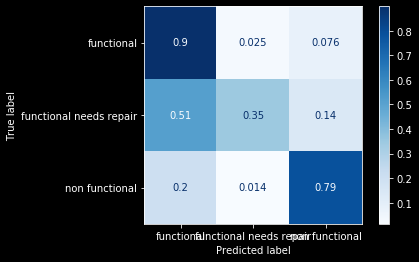

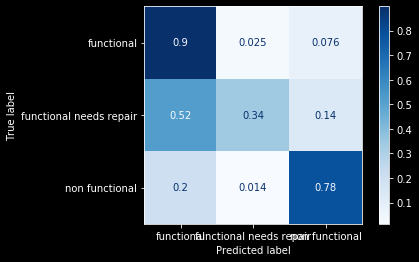

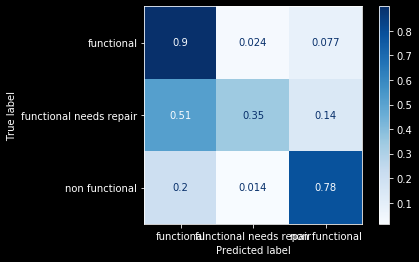

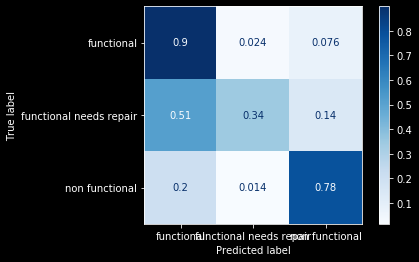

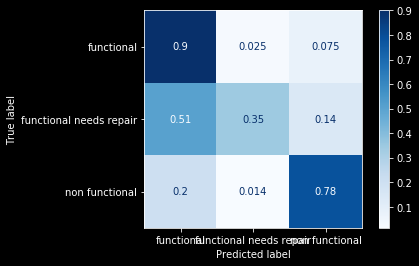

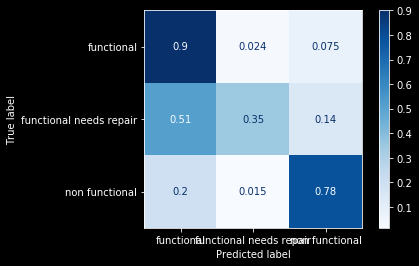

In [13]:
for tuple_item in classifiers:
    plot = learner.plot_confusion_matrix(classifier=tuple_item[2])
plt.show()

In [14]:
#for tuple_item in classifiers:
    #plot = learner.get_cross_validation_score(classifier=tuple_item[2])

In [15]:
for tuple_item in classifiers:
    predicted_output = learner.test_model(classifier=tuple_item[2], file_num=tuple_item[0]+tuple_item[1])

True
True
True
True
True
True
